In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os

In [9]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [11]:
path = kagglehub.dataset_download("khushikyad001/urban-noise-levels")

100%|██████████| 170k/170k [00:00<00:00, 186kB/s]

Extracting files...


In [15]:
csv_path = os.path.join(path, "urban_noise_levels.csv")

In [16]:
df = pd.read_csv(csv_path)

In [17]:
df.shape

(2000, 26)

In [18]:
df.head()

,id,latitude,longitude,datetime,decibel_level,hour,day_of_week,is_weekend,temperature_c,humidity_%,...,population_density,park_proximity,industrial_zone,vehicle_count,honking_events,public_event,holiday,school_zone,noise_complaints,sensor_id
0,1,40.649816,-74.069147,2023-04-01 18:50:00,78.286408,18,5,1,16.710979,43.054747,...,28384,0,0,24,1,0,0,1,1,31
1,2,40.880286,-74.076511,2023-03-18 04:12:00,68.131845,4,5,1,10.088749,29.676246,...,24206,0,0,15,2,0,0,0,0,40
2,3,40.792798,-73.746873,2023-12-03 05:43:00,58.934966,5,6,1,19.911075,47.932832,...,1894,1,0,15,2,0,0,0,0,41
3,4,40.739463,-74.075227,2023-06-20 00:44:00,69.559042,0,1,0,3.477520,88.594010,...,2265,1,0,24,4,0,0,1,2,50
4,5,40.562407,-74.064025,2023-12-28 12:06:00,60.409097,12,3,0,17.356303,35.811699,...,23807,1,0,25,2,0,0,0,0,8


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2000 non-null   int64  
 1   latitude            2000 non-null   float64
 2   longitude           2000 non-null   float64
 3   datetime            2000 non-null   object 
 4   decibel_level       2000 non-null   float64
 5   hour                2000 non-null   int64  
 6   day_of_week         2000 non-null   int64  
 7   is_weekend          2000 non-null   int64  
 8   temperature_c       2000 non-null   float64
 9   humidity_%          2000 non-null   float64
 10  wind_speed_kmh      2000 non-null   float64
 11  precipitation_mm    2000 non-null   float64
 12  traffic_density     2000 non-null   int64  
 13  near_airport        2000 non-null   int64  
 14  near_highway        2000 non-null   int64  
 15  near_construction   2000 non-null   int64  
 16  popula

In [21]:
missing = df.isnull().sum().sort_values(ascending=False)
missing

id                    0
latitude              0
longitude             0
datetime              0
decibel_level         0
hour                  0
day_of_week           0
is_weekend            0
temperature_c         0
humidity_%            0
wind_speed_kmh        0
precipitation_mm      0
traffic_density       0
near_airport          0
near_highway          0
near_construction     0
population_density    0
park_proximity        0
industrial_zone       0
vehicle_count         0
honking_events        0
public_event          0
holiday               0
school_zone           0
noise_complaints      0
sensor_id             0
dtype: int64

## Data Cleaning 

In [22]:
df2 = df.copy()

In [ ]:
if "datetime" in df2.columns:
    df2['datetime'] = pd.to_datetime(df2['datetime'], errors='coerce')  
    print("datetime nulls after parse:", df2['datetime'].isnull().sum())

datetime nulls after parse: 0


In [24]:
int_cols = ['hour', 'day_of_week', 'is_weekend']
for c in int_cols:
    if c in df2.columns:
        df2[c] = pd.to_numeric(df2[c], errors='coerce').astype('Int64')

In [ ]:
dups = df2.duplicated().sum()
print("Duplicate rows (exact):", dups)

In [25]:
if 'latitude' in df2.columns and 'longitude' in df2.columns:
    bad_lat = (~df2['latitude'].between(-90, 90)) | df2['latitude'].isnull()
    bad_lon = (~df2['longitude'].between(-180, 180)) | df2['longitude'].isnull()
    print("Bad latitude count:", bad_lat.sum(), "Bad longitude count:", bad_lon.sum())

Bad latitude count: 0 Bad longitude count: 0


In [26]:
if 'decibel_level' in df2.columns:
    print("decibel min/max:", df2['decibel_level'].min(), df2['decibel_level'].max())
    bad_db = (~df2['decibel_level'].between(0, 200)) | df2['decibel_level'].isnull()
    print("Bad decibel count:", bad_db.sum())

decibel min/max: 33.23296186803999 97.43092969594731
Bad decibel count: 0


In [27]:
for col, (lo, hi) in {
    'temperature_c': (-50, 60),
    'humidity_%': (0, 100),
    'wind_speed_kmh': (0, 200)
}.items():
    if col in df2.columns:
        print(f"{col} out-of-range count:", (~df2[col].between(lo, hi)).sum())

temperature_c out-of-range count: 0
humidity_% out-of-range count: 0
wind_speed_kmh out-of-range count: 0


In [28]:
critical_mask = (
    df2['datetime'].isnull() |
    (~df2['latitude'].between(-90,90)) |
    (~df2['longitude'].between(-180,180)) |
    (~df2['decibel_level'].between(0,200))
)
print("Rows with at least one critical problem:", critical_mask.sum())

Rows with at least one critical problem: 0


In [29]:
frac_critical = critical_mask.mean()
print("Fraction critical:", frac_critical)
if frac_critical < 0.02:
    df_clean = df2[~critical_mask].copy()
    print("Dropped rows with critical issues -> new shape:", df_clean.shape)
else:
    df_clean = df2.copy()

Fraction critical: 0.0
Dropped rows with critical issues -> new shape: (2000, 26)


In [30]:
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()

In [31]:
for c in num_cols:
    if df_clean[c].isnull().any():
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())

for c in cat_cols:
    if df_clean[c].isnull().any():
        df_clean[c] = df_clean[c].fillna("unknown")

print("Remaining nulls:", df_clean.isnull().sum().sum())

Remaining nulls: 0


In [32]:
print("After cleaning shape:", df_clean.shape)
display(df_clean.describe().T)
print("Null counts per column after cleaning:")
display(df_clean.isnull().sum().sort_values(ascending=False).head(20))


After cleaning shape: (2000, 26)


,count,mean,min,25%,50%,75%,max,std
id,2000.0,1000.5,1.0,500.75,1000.5,1500.25,2000.0,577.494589
latitude,2000.0,40.699455,40.501287,40.595219,40.702941,40.800272,40.899887,0.116884
longitude,2000.0,-73.951805,-74.199994,-74.074607,-73.953653,-73.825655,-73.700221,0.14429
datetime,2000,2023-07-01 13:35:27.480000,2023-01-01 03:42:00,2023-04-02 19:35:45,2023-07-03 02:22:00,2023-09-28 20:09:30,2023-12-31 20:31:00,NaN
decibel_level,2000.0,64.81511,33.232962,57.90787,65.019535,71.647588,97.43093,10.069717
hour,2000.0,11.6065,0.0,6.0,12.0,18.0,23.0,6.994149
day_of_week,2000.0,3.06,0.0,1.0,3.0,5.0,6.0,1.966554
is_weekend,2000.0,0.2955,0.0,0.0,0.0,1.0,1.0,0.456381
temperature_c,2000.0,17.696283,-4.547114,12.775756,17.635835,22.756373,40.0,7.165606
humidity_%,2000.0,55.179931,20.003698,37.986261,55.204723,72.396867,89.977124,19.992284


Null counts per column after cleaning:


id                    0
latitude              0
longitude             0
datetime              0
decibel_level         0
hour                  0
day_of_week           0
is_weekend            0
temperature_c         0
humidity_%            0
wind_speed_kmh        0
precipitation_mm      0
traffic_density       0
near_airport          0
near_highway          0
near_construction     0
population_density    0
park_proximity        0
industrial_zone       0
vehicle_count         0
dtype: int64

## Feature Engineering

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

In [ ]:

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')


df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek 


In [35]:
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [36]:
def get_time_period(h):
    if 5 <= h < 12:
        return 'Morning'
    elif 12 <= h < 17:
        return 'Afternoon'
    elif 17 <= h < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_period'] = df['hour'].apply(get_time_period)

In [39]:
cat_cols = ['time_period']  
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

In [40]:
print(df[['datetime', 'hour', 'day_of_week', 'is_weekend', 'time_period']].head())

             datetime  hour  day_of_week  is_weekend  time_period
0 2023-04-01 18:50:00    18            5           1            1
1 2023-03-18 04:12:00     4            5           1            3
2 2023-12-03 05:43:00     5            6           1            2
3 2023-06-20 00:44:00     0            1           0            3
4 2023-12-28 12:06:00    12            3           0            0


## Normalization & Standardization

In [41]:
numeric_cols = ['temperature_c', 'humidity_%', 'wind_speed', 'hour', 'day_of_week', 'month']

In [42]:
numeric_cols = [col for col in numeric_cols if col in df.columns]

In [43]:
standard_scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[numeric_cols] = standard_scaler.fit_transform(df_standardized[numeric_cols])

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [46]:
minmax_scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numeric_cols] = minmax_scaler.fit_transform(df_normalized[numeric_cols])

In [47]:
print("Standardized sample:")
print(df_standardized[numeric_cols].head())


Standardized sample:
   temperature_c  humidity_%      hour  day_of_week     month
0      -0.137539   -0.606645  0.914350     0.986744 -0.727523
1      -1.061939   -1.275995 -1.087824     0.986744 -1.018474
2       0.309164   -0.362585 -0.944812     1.495375  1.600085
3      -1.984803    1.671767 -1.659874    -1.047780 -0.145621
4      -0.047458   -0.969028  0.056275    -0.030518  1.600085


In [48]:
print("\nNormalized sample:")
print(df_normalized[numeric_cols].head())


Normalized sample:
   temperature_c  humidity_%      hour  day_of_week     month
0       0.477205    0.329426  0.782609     0.833333  0.272727
1       0.328548    0.138232  0.173913     0.833333  0.181818
2       0.549041    0.399139  0.217391     1.000000  1.000000
3       0.180138    0.980234  0.000000     0.166667  0.454545
4       0.491691    0.225914  0.521739     0.500000  1.000000


## EDA

In [49]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

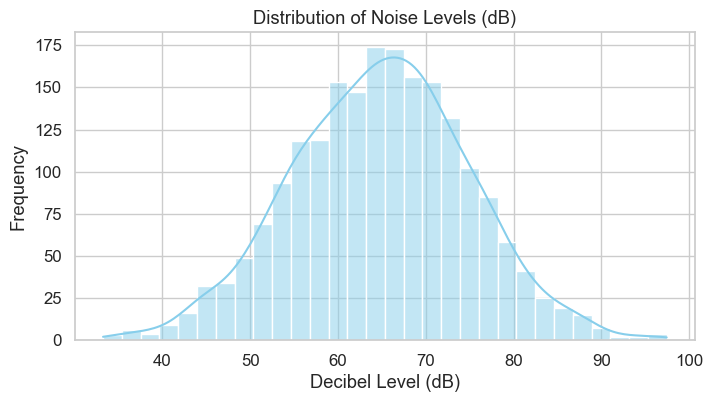

In [50]:
plt.figure(figsize=(8, 4))
sns.histplot(df['decibel_level'], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Noise Levels (dB)")
plt.xlabel("Decibel Level (dB)")
plt.ylabel("Frequency")
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_19352\3920146238.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='decibel_level', data=df, palette='coolwarm')


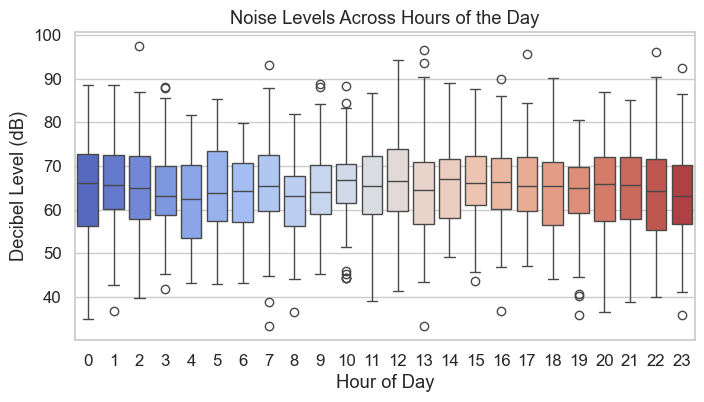

In [51]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='hour', y='decibel_level', data=df, palette='coolwarm')
plt.title("Noise Levels Across Hours of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Decibel Level (dB)")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_19352\3728282600.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_weekend', y='decibel_level', data=df, palette='Set2')


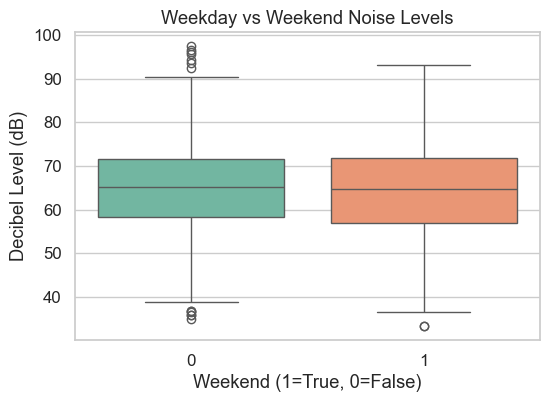

In [52]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='is_weekend', y='decibel_level', data=df, palette='Set2')
plt.title("Weekday vs Weekend Noise Levels")
plt.xlabel("Weekend (1=True, 0=False)")
plt.ylabel("Decibel Level (dB)")
plt.show()

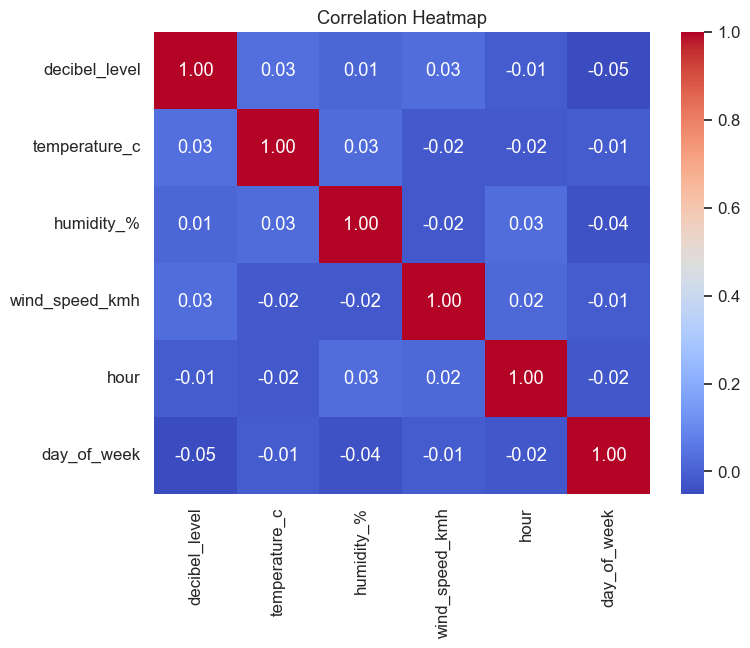

In [54]:
numeric_features = ['decibel_level', 'temperature_c', 'humidity_%', 'wind_speed_kmh', 'hour', 'day_of_week']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

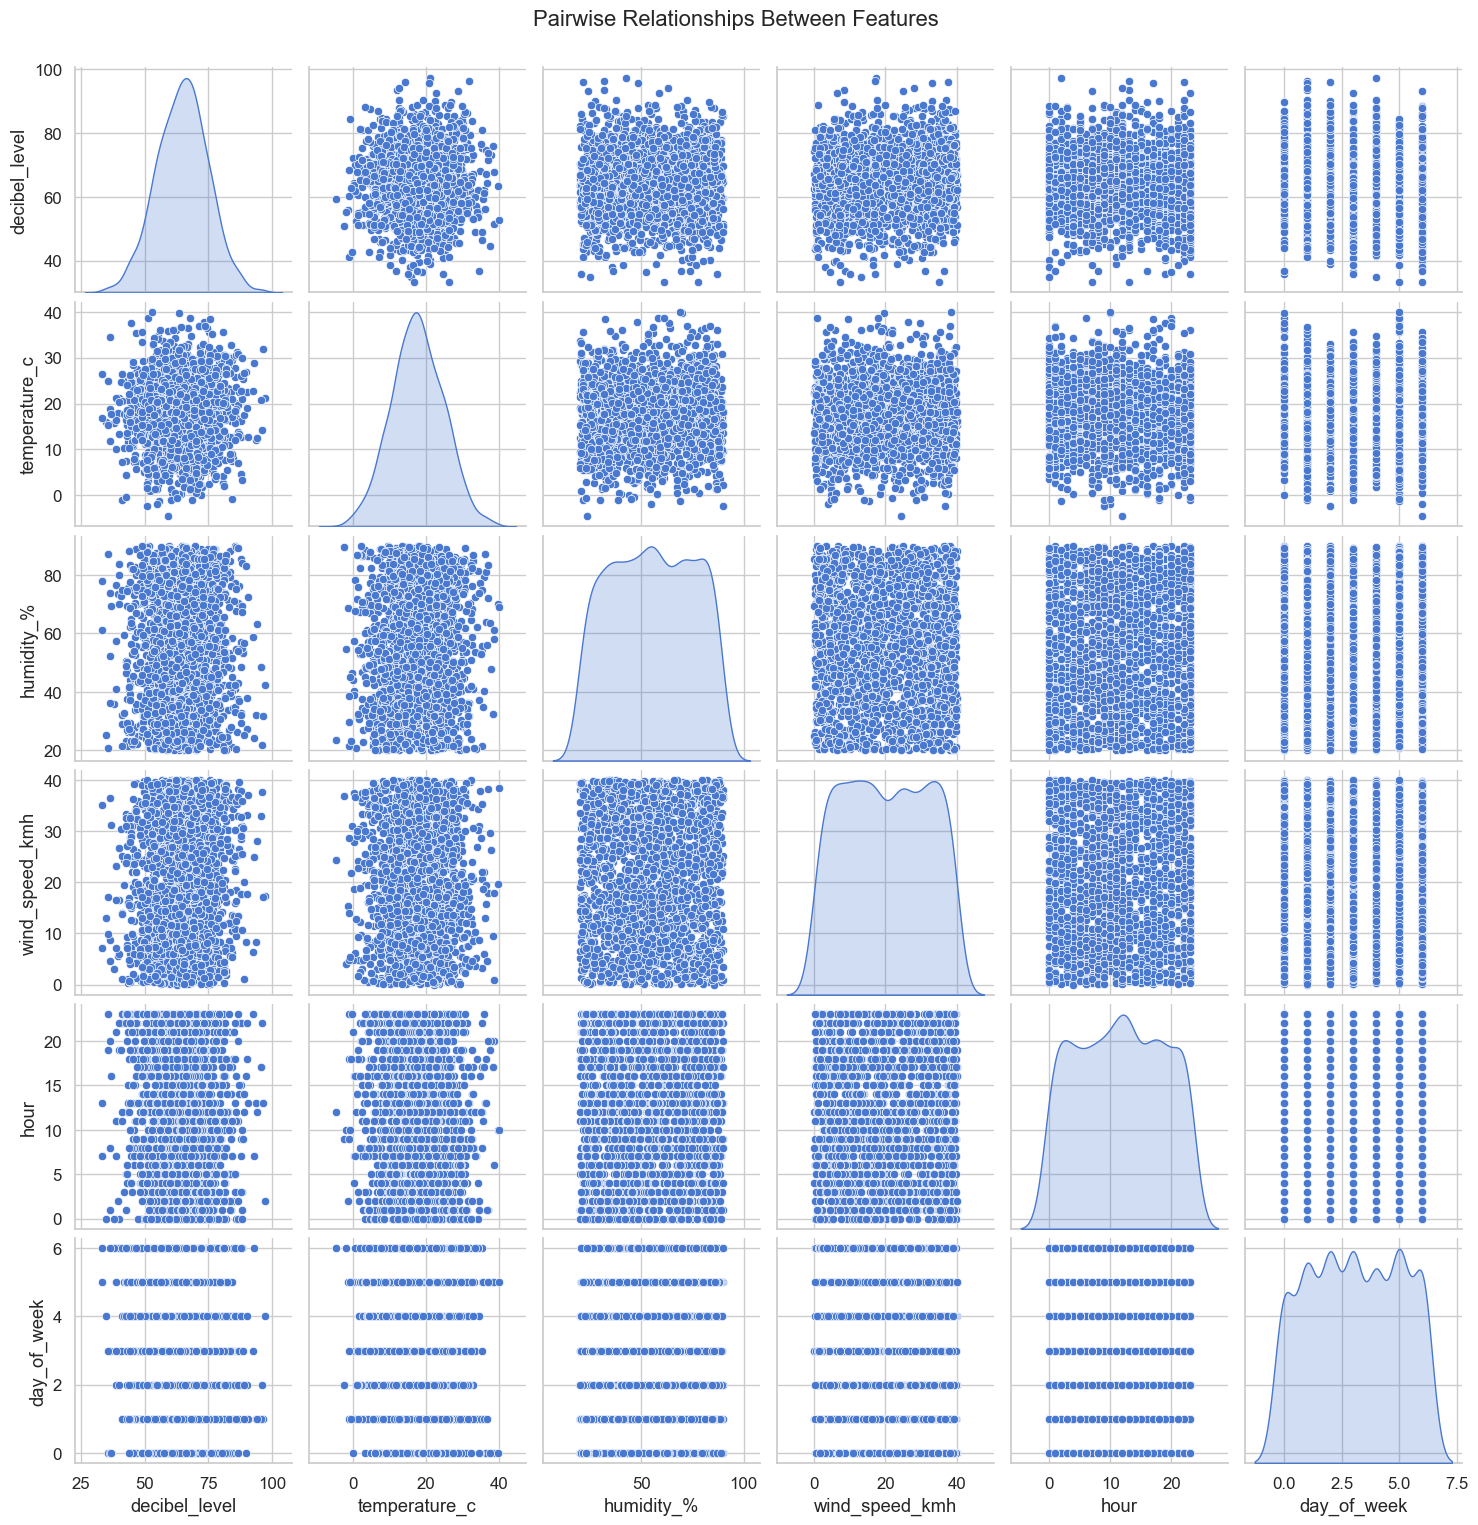

In [55]:
sns.pairplot(df[numeric_features], diag_kind="kde")
plt.suptitle("Pairwise Relationships Between Features", y=1.02)
plt.show()

## Feature Selection

In [ ]:

correlations = df.corr(numeric_only=True)['decibel_level'].sort_values(ascending=False)
print("Correlation with decibel_level:\n", correlations)


Correlation with decibel_level:
 decibel_level         1.000000
traffic_density       0.038723
temperature_c         0.031700
wind_speed_kmh        0.029078
longitude             0.011358
humidity_%            0.010947
vehicle_count         0.006006
precipitation_mm      0.003278
public_event          0.001152
near_airport          0.001000
school_zone           0.000263
id                   -0.004448
honking_events       -0.005628
near_construction    -0.007439
hour                 -0.012000
industrial_zone      -0.013112
sensor_id            -0.015782
park_proximity       -0.016123
latitude             -0.025302
day                  -0.030307
near_highway         -0.033294
is_weekend           -0.037915
time_period          -0.039649
holiday              -0.040923
noise_complaints     -0.041124
population_density   -0.041593
month                -0.043864
day_of_week          -0.051268
year                       NaN
Name: decibel_level, dtype: float64


## Model Fitting

In [57]:
feature_cols = ['latitude', 'longitude', 'hour', 'day_of_week', 'is_weekend',
                'temperature_c', 'humidity_%']
target_col = 'decibel_level'

X = df[feature_cols]
y = df[target_col]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


LinearRegression()

In [60]:
y_pred_lr = lin_reg.predict(X_test)

In [61]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [62]:
y_pred_rf = rf_model.predict(X_test)

In [63]:
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)


In [64]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Linear Regression → MSE: {mse_lr:.2f}, R²: {r2_lr:.3f}")
print(f"Random Forest     → MSE: {mse_rf:.2f}, R²: {r2_rf:.3f}")

Linear Regression → MSE: 107.65, R²: 0.007
Random Forest     → MSE: 113.87, R²: -0.051


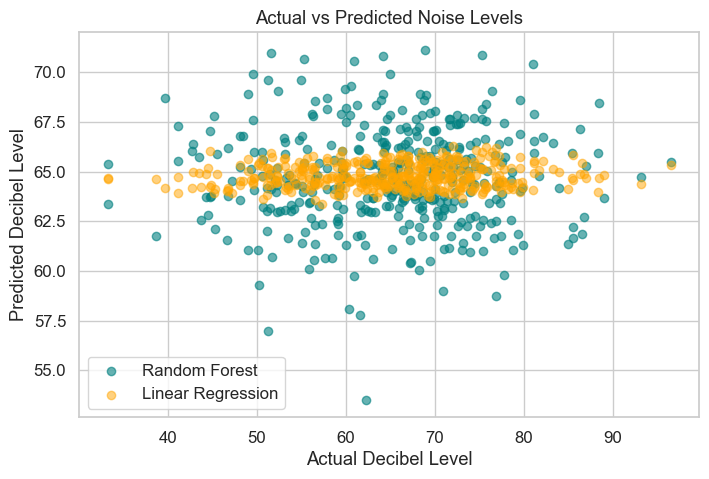

In [65]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Random Forest', color='teal')
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Linear Regression', color='orange')
plt.xlabel("Actual Decibel Level")
plt.ylabel("Predicted Decibel Level")
plt.title("Actual vs Predicted Noise Levels")
plt.legend()
plt.show()


## Prediction & Interpretation

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
X = df[["hour", "temperature_c", "humidity_%", "wind_speed_kmh", "is_weekend"]]
y = df["decibel_level"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Model Evaluation Results:
Mean Absolute Error (MAE): 8.32
Root Mean Squared Error (RMSE): 10.38
R² Score: 0.01


## Visualization of Results

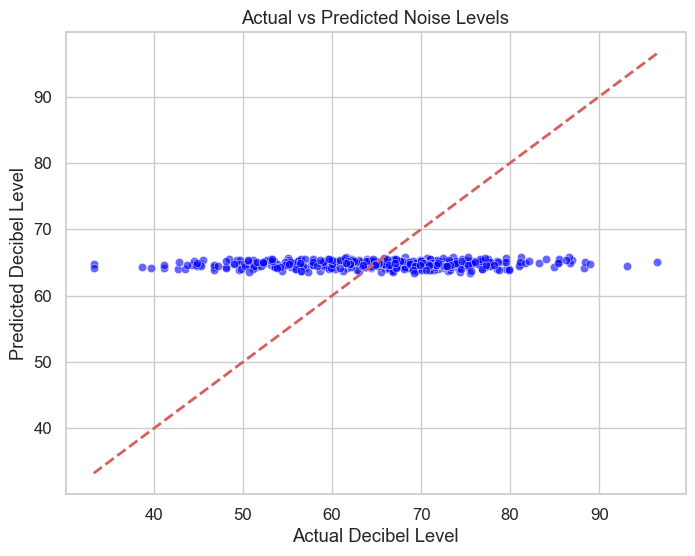

In [70]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue", alpha=0.6)
plt.xlabel("Actual Decibel Level")
plt.ylabel("Predicted Decibel Level")
plt.title("Actual vs Predicted Noise Levels")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # ideal line
plt.show()

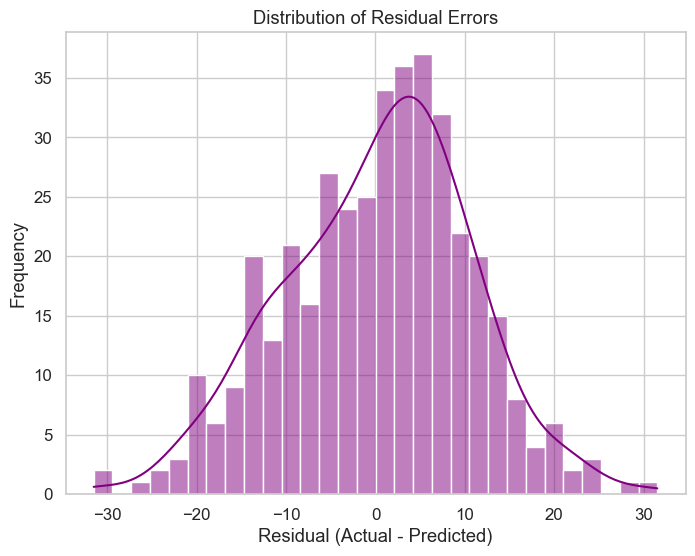

In [71]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.title("Distribution of Residual Errors")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

In [73]:
from sklearn.tree import DecisionTreeRegressor

In [74]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=6),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100, max_depth=8)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "R2": r2}

# Display results
import pandas as pd
results_df = pd.DataFrame(results).T
print("\nModel Comparison Results:")
print(results_df)



Model Comparison Results:
                        RMSE        R2
Linear Regression  10.380900  0.005626
Decision Tree      10.738965 -0.064155
Random Forest      10.483441 -0.014116


C:\Users\user\AppData\Local\Temp\ipykernel_19352\3424380764.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["R2"], palette="coolwarm")


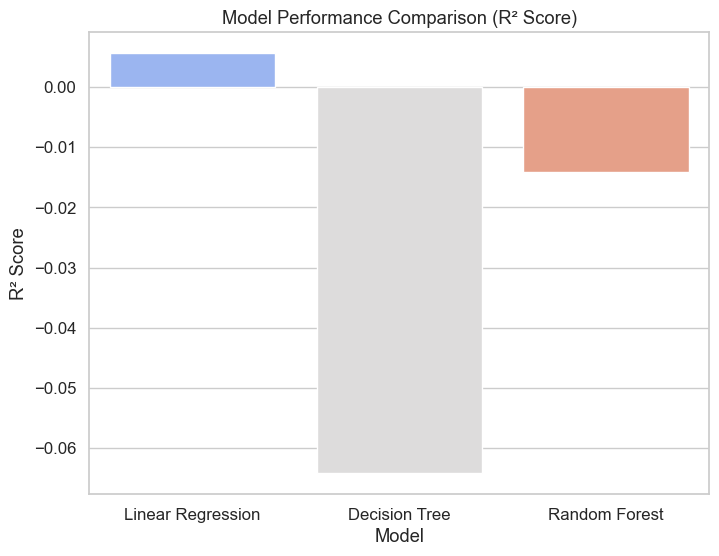

In [75]:
plt.figure(figsize=(8, 6))
sns.barplot(x=results_df.index, y=results_df["R2"], palette="coolwarm")
plt.title("Model Performance Comparison (R² Score)")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.show()